In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
# 텍스트 데이터를 머신러닝 알고리즘이 처리할 수 있는 수치 벡터로 변환
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertModel
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [16]:
from google.colab import drive
drive.mount('/content/drive')

In [299]:
df = pd.read_csv("/content/drive/MyDrive/법률모델링/divorce_topic_labeled_new.csv", encoding="utf-8-sig")


===== Epoch 1/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.5040 | Train F1: 0.2124
Val Loss: 1.4919 | Val F1: 0.2455
✅ 모델 저장!

===== Epoch 2/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.3610 | Train F1: 0.2453
Val Loss: 1.3842 | Val F1: 0.2815
✅ 모델 저장!

===== Epoch 3/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.1630 | Train F1: 0.3113
Val Loss: 1.1514 | Val F1: 0.4385
✅ 모델 저장!

===== Epoch 4/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.9866 | Train F1: 0.4487
Val Loss: 1.1279 | Val F1: 0.3902

===== Epoch 5/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8464 | Train F1: 0.5247
Val Loss: 1.0255 | Val F1: 0.4392
✅ 모델 저장!

===== Epoch 6/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7129 | Train F1: 0.5616
Val Loss: 0.9537 | Val F1: 0.6031
✅ 모델 저장!

===== Epoch 7/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6080 | Train F1: 0.6416
Val Loss: 0.9464 | Val F1: 0.6056
✅ 모델 저장!

===== Epoch 8/8 =====


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5627 | Train F1: 0.7463
Val Loss: 0.9429 | Val F1: 0.6103
✅ 모델 저장!

=== Classification Report ===
                  precision    recall  f1-score   support

      이혼 시 금전 문제       0.69      0.82      0.75        22
혼인 파탄의 원인과 법적 책임       0.50      0.12      0.20         8
부정행위 및 제3자 개입 책임       0.78      0.91      0.84        44
   위자료 및 손해배상 청구       0.87      0.85      0.86        61
    부정행위의 법률적 근거       0.67      0.29      0.40         7

        accuracy                           0.80       142
       macro avg       0.70      0.60      0.61       142
    weighted avg       0.78      0.80      0.78       142



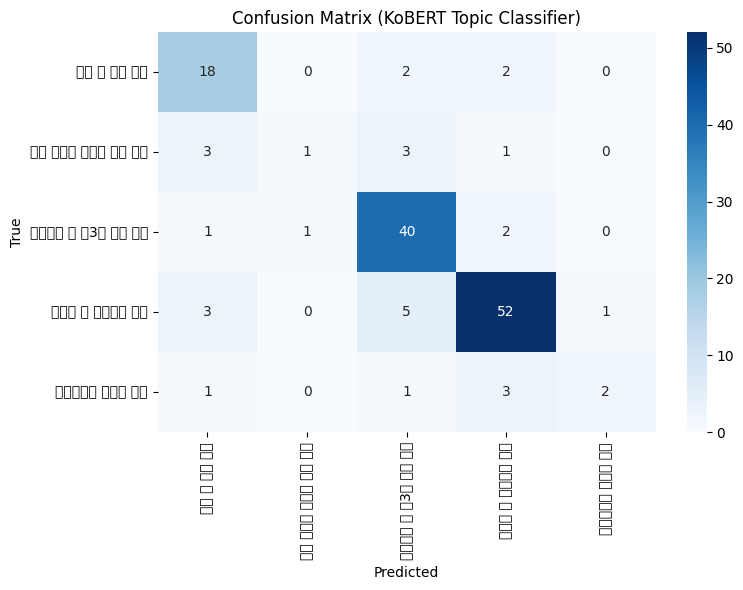

In [29]:
# ==============================================
# 3. Dataset 정의
# ==============================================
class DivorceTopicDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.loc[idx, "input"])
        label = int(self.data.loc[idx, "topic_label"])

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


# ==============================================
# 4. 모델 정의 (KoBERT + Classifier Head)
# ==============================================
class KoBERTClassifier(nn.Module):
    def __init__(self, n_classes=5, dropout=0.2):
        super(KoBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] 벡터
        x = self.dropout(pooled_output)
        return self.classifier(x)

# ==============================================
# 5. 데이터 분할 및 DataLoader
# ==============================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
dataset = DivorceTopicDataset(df, tokenizer, MAX_LEN)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ==============================================
# 6. 학습 준비
# ==============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KoBERTClassifier(n_classes=5).to(device)

# 클래스 가중치 계산
class_counts = df["topic_label"].value_counts().sort_index()
class_weights = 1.0 / np.sqrt(class_counts.values)
class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

# ==============================================
# 7. 학습 함수
# ==============================================
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    preds, trues = [], []

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

    f1 = f1_score(trues, preds, average="macro")
    return total_loss / len(loader), f1

# ==============================================
# 8. 검증 함수
# ==============================================
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds, trues = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attn_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    f1 = f1_score(trues, preds, average="macro")
    return total_loss / len(loader), f1, trues, preds

# ==============================================
# 9. 학습 루프
# ==============================================
best_f1 = 0
for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    train_loss, train_f1 = train_epoch(model, train_loader)
    val_loss, val_f1, y_true, y_pred = eval_epoch(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), '/content/drive/MyDrive/법률모델링/best_kobert_topic.pt')
        print("✅ 모델 저장!")

# ==============================================
# 10. 결과 리포트 및 시각화
# ==============================================
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=label_name_map.values()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_name_map.values(), yticklabels=label_name_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (KoBERT Topic Classifier)")
plt.tight_layout()
plt.show()


In [20]:
MODEL_NAME = "monologg/kobert"
MODEL_PATH = "'/content/drive/MyDrive/법률모델링/best_kobert_topic.pt')"  # 모델 저장 경로와 일치해야 함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# ==============================================
# 2. 모델 클래스 정의 (학습 때와 동일)
# ==============================================
class KoBERTClassifier(nn.Module):
    def __init__(self, n_classes=6, dropout=0.3):
        super(KoBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

# ==============================================
# 3. 모델 로드
# ==============================================
def load_model():
    model = KoBERTClassifier(n_classes=len(label_name_map))
    model.load_state_dict(torch.load("/content/drive/MyDrive/법률모델링/best_kobert_topic.pt", map_location=device))
    model.to(device)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    return model, tokenizer

model, tokenizer = load_model()

# ==============================================
# 4. 예측 함수
# ==============================================
def predict_topic(texts, top_k=1):
    """
    texts: str or List[str]
    top_k: 상위 k개 토픽 반환 (기본값 1)
    """
    if isinstance(texts, str):
        texts = [texts]

    results = []

    for text in texts:
        # 입력 토큰화
        encoding = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=128
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

        top_indices = probs.argsort()[::-1][:top_k]

        top_predictions = [
            {
                "topic_id": int(idx),
                "topic_name": label_name_map[idx],
                "confidence": round(float(probs[idx]), 4)
            }
            for idx in top_indices
        ]

        results.append({
            "input": text,
            "predictions": top_predictions
        })

    return results

# ==============================================
# 5. 사용 예시
# ==============================================
if __name__ == "__main__":
    sample_inputs = [
        "배우자가 부정행위를 했는데 위자료 청구가 가능할까요?",
        "이혼 후 양육비를 지급하지 않으면 어떻게 되나요?",
        "제3자가 우리 부부 사이에 끼어들었어요.",
        "민법 제840조에 근거해서 이혼 사유가 되나요?"
    ]

    preds = predict_topic(sample_inputs)
    for p in preds:
        print(f"\n💬 입력: {p['input']}")
        for r in p["predictions"]:
            print(f"➡️ 예측 토픽: {r['topic_name']} (conf={r['confidence']})")


💬 입력: 배우자가 부정행위를 했는데 위자료 청구가 가능할까요?
➡️ 예측 토픽: 위자료 및 손해배상 청구 (conf=0.8555)

💬 입력: 이혼 후 양육비를 지급하지 않으면 어떻게 되나요?
➡️ 예측 토픽: 이혼 시 금전 문제 (conf=0.6165)

💬 입력: 제3자가 우리 부부 사이에 끼어들었어요.
➡️ 예측 토픽: 부정행위 및 제3자 개입 책임 (conf=0.7954)

💬 입력: 민법 제840조에 근거해서 이혼 사유가 되나요?
➡️ 예측 토픽: 이혼 시 금전 문제 (conf=0.2956)


In [308]:
mapping = {0: 0, 2: 1, 3: 2, 4: 3}

# 2. 데이터프레임의 'topic_label' 열에 매핑 적용
df['topic_label'] = df['topic_label'].map(mapping)

# 3. 변경 후 결과 확인
print(df['topic_label'].value_counts())

topic_label
2    256
1    248
0    103
3     77
Name: count, dtype: int64


In [302]:
print(df['topic_label'].value_counts())

topic_label
3    256
2    248
0    103
4     77
Name: count, dtype: int64


In [310]:
label_name_map = {
    0: "이혼 시 금전 문제 (재산분할·양육비)",
    1: "부정행위 및 제3자 개입 책임",
    2: "위자료 및 손해배상 청구",
    3: "부정행위의 법률적 근거"
}

In [284]:
df.drop(644	, axis=0, inplace=True)
# 옮길 ID 목록
move_ids = [488]

# 해당 행들의 topic을 4번으로 변경
df.loc[move_ids, "topic_label"] = 3
df.loc[move_ids, "topic_name"] = "위자료 및 손해배상 청구"

In [307]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', 5)
df.loc[df["topic_name"] == "부정행위의 법률적 근거"]

,input,output,input_processed,is_divorce,topic_label,super_category,topic_name,topic_probability,announce_date
11,이혼을 재판으로 청구하려면 어떤 법적 근거가 필요한가요?,NaN,NaN,NaN,4,NaN,부정행위의 법률적 근거,NaN,NaN
28,혼인 중 아내가 임신하여 출산한 자녀는 어떠한 경우 남편의 친생자로 추정되나요?,"민법 제844조 제1항에 따르면, 혼인 중 아내가 임신하여 출산한 자녀는 남편의 친생자로 추정됩니다. 이는 남편이 자녀의 친생자관계를 부인하기 위해서는 소 제기와 판결을 통해 이를 부인해야 한다는 것입니다.",혼인 아내 임신 출산 자녀 남편 친생자 추정,1.0,4,불법행위_책임,부정행위의 법률적 근거,0.871915,2021-10-13T09:00:00.000+09:00
...,...,...,...,...,...,...,...,...,...
672,부부는 민법상 어떤 의무와 권리를 가지나요?,"민법 제826조에 따르면, 부부는 동거하며 서로 부양하고 협조할 의무를 가지며, 정신적·육체적·경제적으로 결합된 공동체로서 서로 협조하고 보호할 의무를 가집니다. 또한, 부부는 부정행위를 하지 아니할 성적 성실 의무를 부담하며, 이러한 의무를 이행하는 데에 관한 권리를 가집니다.",부부 민법 의무 권리,1.0,4,불법행위_책임,부정행위의 법률적 근거,0.871924,2019-07-11T09:00:00.000+09:00
683,사실혼 관계에서 귀책사유를 인정하기 위한 기준은 무엇인가요?,"사실혼 관계에서 귀책사유를 인정하기 위해서는 당사자 쌍방이 서로의 문제를 해결하기 위한 노력을 기울였는지 여부를 고려해야 합니다. 대법원 2010. 7. 29. 선고 2008므1475 판결에 따르면, 혼인생활 중 발생한 갈등이나 불화는 단편적인 행위로 인해 즉각적으로 파탄에 이를 수 없으며, 부부는 이러한 장애를 극복하기 위해 이해와 대화를 통한 적극적 노력을 하여야 할 의무가 있습니다.",사실혼 관계 귀책사유 기준,1.0,4,위자료_관련,부정행위의 법률적 근거,0.789192,2021-12-17T09:00:00.000+09:00


In [48]:
new_samples = [
    "법적으로 이혼이 인정되는 사유에는 어떤 것들이 있나요?",
    "이혼이 가능한 조건은 법에서 어떻게 정해져 있나요?",
    "배우자의 외도가 법적으로 이혼 사유가 될 수 있나요?",
    "법원에서 인정하는 ‘부정행위’의 기준은 무엇인가요?",
    "법적으로 혼인을 유지하기 어려운 경우는 어떤 상황을 말하나요?",
    "이혼을 재판으로 청구하려면 어떤 법적 근거가 필요한가요?",
    "단순한 연락이나 애정 표현도 법적으로 부정행위로 보나요?",
    "법에서 말하는 ‘혼인 파탄’은 구체적으로 어떤 상태를 의미하나요?",
    "배우자가 폭력을 행사할 경우, 법적으로 이혼 사유가 되나요?",
    "법적으로 정해진 이혼 사유는 총 몇 가지인가요?",
    "법원은 어떤 기준으로 ‘혼인 관계가 파탄됐다’고 판단하나요?",
    "외도가 아니라 정서적인 배신도 법적으로 부정행위로 인정되나요?",
    "법에서 인정하는 ‘혼인 유지가 어려운 중대한 사유’에는 어떤 게 있나요?",
    "배우자의 장기 별거가 법적으로 이혼 사유가 되나요?",
    "재판에서 ‘이혼을 청구할 수 있는 사유’는 무엇으로 정해지나요?",
    "배우자가 집을 나간 경우, 법적으로 이혼이 가능할까요?",
    "법에서 정한 ‘악의의 유기’는 어떤 행위를 말하나요?",
    "서로 다투다가 별거한 경우에도 법적으로 이혼이 인정될 수 있나요?",
    "부부 간의 갈등이 심할 때, 법적으로 이혼 청구가 가능한 기준은 있나요?",
    "법원은 어떤 증거가 있어야 이혼 사유로 인정하나요?",
    "배우자가 종교 문제나 가치관 차이로 가정을 돌보지 않으면 이혼 사유인가요?",
    "부부 간 폭언이나 경멸적인 태도도 법에서 이혼 사유로 인정되나요?",
    "장기간 연락이 끊긴 경우 법적으로 이혼이 가능할까요?",
    "서로 합의가 안 되는 경우에도 법에서 정한 이혼 절차로 진행할 수 있나요?",
    "배우자의 반복적인 거짓말이나 배신이 법적으로 이혼 사유로 해당되나요?"
]


In [298]:
df.to_csv("/content/drive/MyDrive/법률모델링/divorce_topic_labeled_new.csv", index=False, encoding="utf-8-sig")

In [50]:
new_df = pd.DataFrame({
    "input": new_samples,
    "topic_label": [4] * len(new_samples),
    "topic_name": ["부정행위의 법률적 근거"] * len(new_samples)
})

merged_df = pd.concat([df, new_df], ignore_index=True)
merged_df.drop_duplicates(subset=["input"], inplace=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

merged_df.to_csv("/content/drive/MyDrive/법률모델링/divorce_topic_labeled_augmented.csv", index=False, encoding="utf-8-sig")

print(f"✅ 데이터 보강 완료! 총 {len(merged_df)}개 샘플로 저장됨.")
print("📁 파일명: divorce_topic_labeled_augmented.csv")
print("   (원본 + 민법 제840조 관련 문장 20개 추가)")

✅ 데이터 보강 완료! 총 729개 샘플로 저장됨.
📁 파일명: divorce_topic_labeled_augmented.csv
   (원본 + 민법 제840조 관련 문장 20개 추가)
